In [53]:
## This script is to plot probability of rain
import warnings
warnings.filterwarnings('ignore')
from netCDF4 import Dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np
import xarray as xr
import time
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, ALL_TIMES)
def read_latlon(path,ncfile):
    fname = path + ncfile
    ds = Dataset(fname,'r')
    lat = ds.variables['XLAT'][0,:,:]
    lon = ds.variables['XLONG'][0,:,:]
    return lat,lon

In [ ]:
# Open the NetCDF file
path = '/Users/luongtm/Documents/S2S/Sep-Forecast/NOV30_forecast/'
file = path + 'data/Rain.2023-11-30.nc'
ds = Dataset(file)
prnc = ds.variables['RAINNC'][:,:,:,:]
dataset = xr.open_dataset(file)
pr = dataset['RAINNC']
sn = dataset['SNOWNC'] + dataset['GRAUPELNC']

#latlonf = 'data/latlon.nc'
#lats,lons = read_latlon(path,latlonf)

ncfile = Dataset(file)
rain = getvar(ncfile, "RAINNC", timeidx=ALL_TIMES)

# Get the latitude and longitude points
lats, lons = latlon_coords(rain)

# Get the cartopy mapping object
cart_proj = get_cartopy(rain)
xlim = cartopy_xlim(rain)
ylim = cartopy_ylim(rain)

dmask = Dataset(path + 'data/mask.nc')
dm = dmask.variables['__xarray_dataarray_variable__'][:,:]
m = dm.astype('float')
m[m==0] = np.nan

In [78]:
float(ylim[0])*0.9


-1205998.200271863

In [3]:
nens,nweek,ny,nx = pr.shape
print(pr.shape,lons.shape,lats.shape)

(51, 6, 671, 767) (671, 767) (671, 767)


In [4]:
## count beyond threshold in mm
thres = 1
prb = []
for iw in range(6):
    r_thresh = prnc[:,iw,:,:].copy()
    r_thresh[r_thresh < thres] = False
    r_thresh[r_thresh >= thres] = True
    r_tn = r_thresh.copy()
    r_tn[r_tn > 0] = 1
    r_sum = np.nansum(r_tn,axis=0)
    prob = 100 * (r_sum / nens)*m
    prb.append(prob)
PROB = np.array(prb)
print(PROB.shape)

(6, 671, 767)


In [5]:
## count the ens mean
ens_mean = np.mean(pr,axis=0)
print(ens_mean.shape)

(6, 671, 767)


In [6]:
# Create precip color map
nws_precip_colors = [
    "#fdfdfd",  # 10.00+
    "#04e9e7",  # 0.01 - 0.10 inches
    "#019ff4",  # 0.10 - 0.25 inches
    "#0300f4",  # 0.25 - 0.50 inches
    "#02fd02",  # 0.50 - 0.75 inches
    "#01c501",  # 0.75 - 1.00 inches
    "#008e00",  # 1.00 - 1.50 inches
    "#fdf802",  # 1.50 - 2.00 inches
    "#e5bc00",  # 2.00 - 2.50 inches
    "#fd9500",  # 2.50 - 3.00 inches
    "#fd0000",  # 3.00 - 4.00 inches
    "#d40000",  # 4.00 - 5.00 inches
    "#bc0000",  # 5.00 - 6.00 inches
    "#f800fd",  # 6.00 - 8.00 inches
    "#9854c6"  # 8.00 - 10.00 inches
]
precip_colormap = mpl.colors.ListedColormap(nws_precip_colors)

In [91]:
# Create a figure 
def plot(var,prec,r,thres,t,unit,levels):
    fig = plt.figure(figsize=(8,6))
    # Set the GeoAxes to the projection used by WRF
    # cart_proj = ccrs.PlateCarree()
    ax = plt.axes(projection=cart_proj)

    norm = mpl.colors.BoundaryNorm(levels, 15)

    # Download and add the states and coastlines
    ax.add_feature(cf.BORDERS,zorder=3)
    #ax.add_feature(cf.STATES,zorder=3)
    ax.add_feature(cf.COASTLINE,zorder=3)
    ax.coastlines('10m', linewidth=0.8)

#    plt.contourf(to_np(lons), to_np(lats), to_np(prec), levels,
    plt.pcolormesh(lons, lats, prec,
             transform=ccrs.PlateCarree(),
             cmap=precip_colormap, norm=norm)
    # Add a color bar
    plt.colorbar(ax=ax, shrink=.9, ticks = levels)

    # Set the map bounds
    #ax.set_xlim(31.28, 61.26)
    #ax.set_ylim(9.69, 33.56)
    #ax.set_xlim(34, 50)
    #ax.set_ylim(16, 32.5)
    #ax.set_xlim(34, 38)
    #ax.set_ylim(26, 30)
    ax.set_ylim(float(ylim[0])*0.6,float(ylim[1])*0.9)
    ax.set_xlim(float(xlim[0])*0.8,float(xlim[1])*0.8)
    
    ## get loc markers
    lonc = [42.51,41.47,41.02,40.20,39.85,39.61,43.79,46.71,41.68,36.57,44.13,49.9,42.56]
    latc = [18.22,20.01,30.98,29.97,21.38,24.47,26.33,24.63,27.51,28.39,17.49,26.4,16.89]
    city = ['Abha','Al-Bahah',"Arar",'Sakaka','Mecca','Madinah','Buraidah','Riyadh','Hail','Tabuk','Najran','Dammam','Jizan']
    #lonc = [36.57]
    #latc = [28.39]
    #city = ['Tabuk']
    for ic in range(len(city)):
        lat_loc = latc[ic]
        lon_loc = lonc[ic]
        ax.plot(lon_loc,lat_loc, marker='.', markerfacecolor='none',
             markeredgecolor='k', markersize=5, transform=projection,zorder=11)
        ax.annotate(city[ic],(lon_loc-0.5,lat_loc+0.3),transform=projection,fontsize=8, fontname='serif',)
        #ax.annotate(city[ic],(lon_loc,lat_loc+0.1),transform=projection, fontsize=10, fontname='serif',)
    
    # Add the gridlines
    ax.gridlines(color='black', linestyle='dotted')

    plt.title(str(r)+' of '+var+' > '+str(thres)+' mm/week at week '+str(t+1)+unit)
    plt.show()
    fig.savefig(path+var+'_t'+str(t+1)+'_e'+str(r)+'_'+str(thres)+'mm.png', dpi=200)
    plt.close()

1001


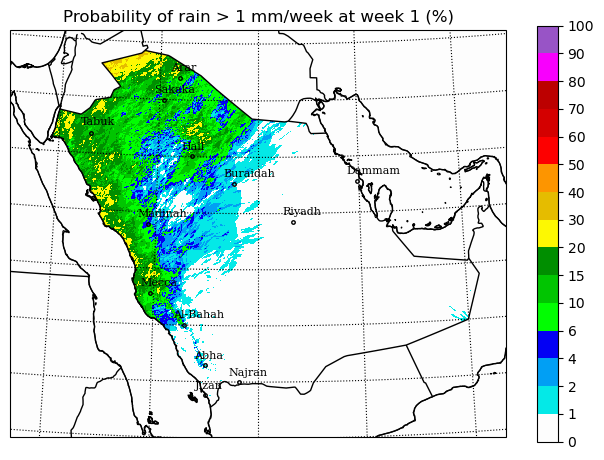

In [92]:
levels = [0, 1, 2, 4, 6, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
norm = mpl.colors.BoundaryNorm(levels, 15)
projection = ccrs.PlateCarree()
for t in range(0,1):
        print((t+1)*1000+thres)
        prec = pr.isel(Time=t)*m
        start_time = time.time()
        prob = xr.where(prec>thres,100,0)
        levels = [0, 1, 2, 4, 6, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        plot('rain',prob.mean(dim='record',skipna=True),'Probability',thres,t,' (%)',levels)

1001


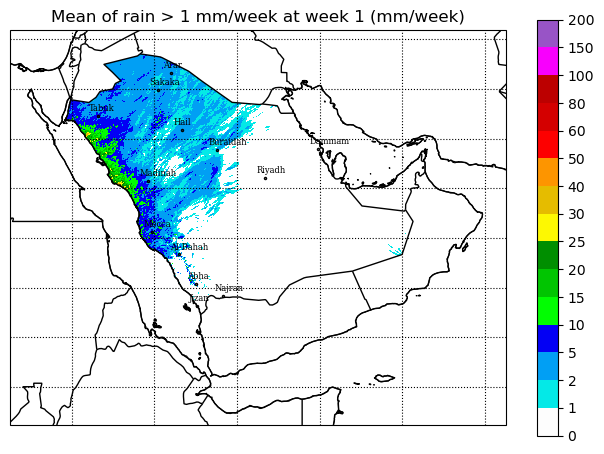

2001


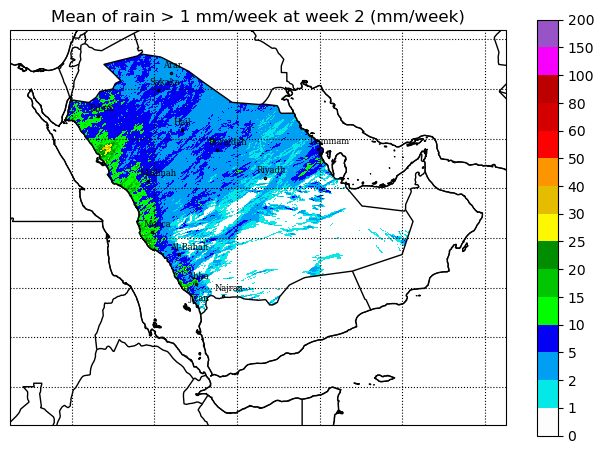

3001


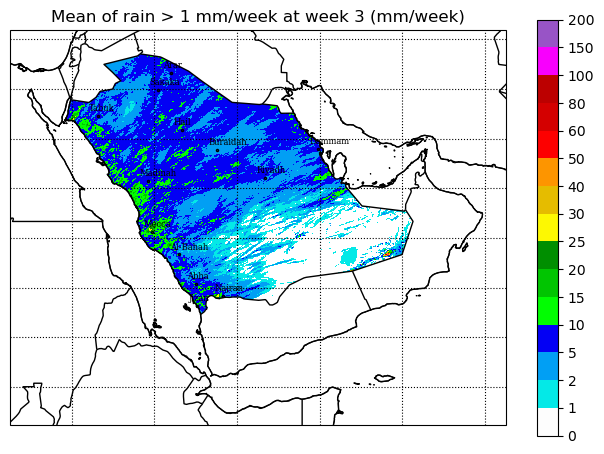

4001


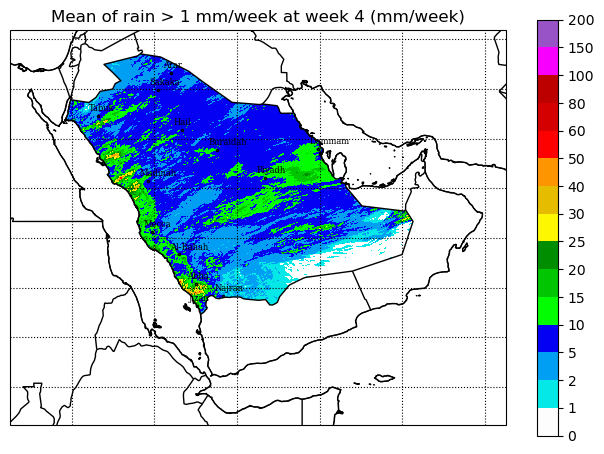

5001


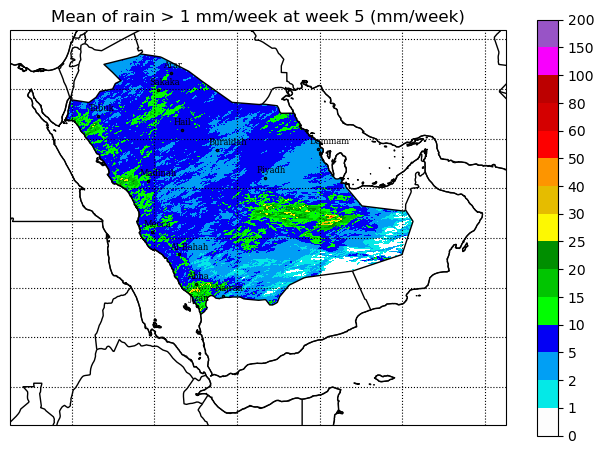

6001


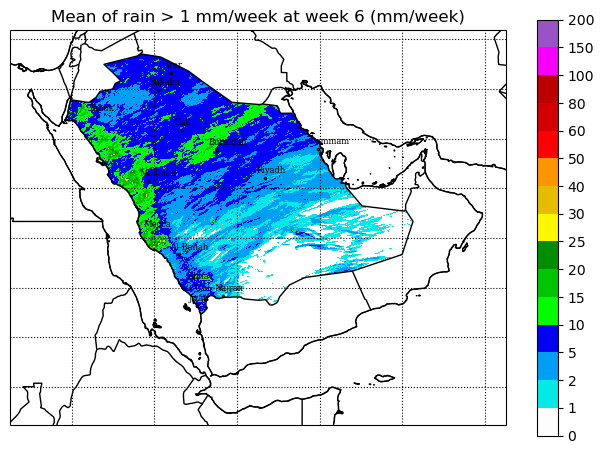

In [24]:
projection = ccrs.PlateCarree()
levels = [0, 1, 2, 5, 10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 150, 200]
for t in range(0,6):
        print((t+1)*1000+thres)
        prec = pr.isel(Time=t)*m
        start_time = time.time()
        emean = xr.where(prec>thres,prec,np.nan)
        plot('rain',emean.mean(dim='record', skipna=True),'Mean',thres,t,' (mm/week)',levels)

1001


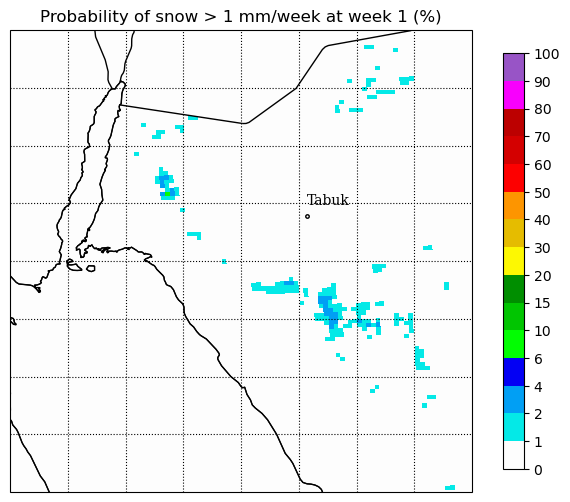

2001


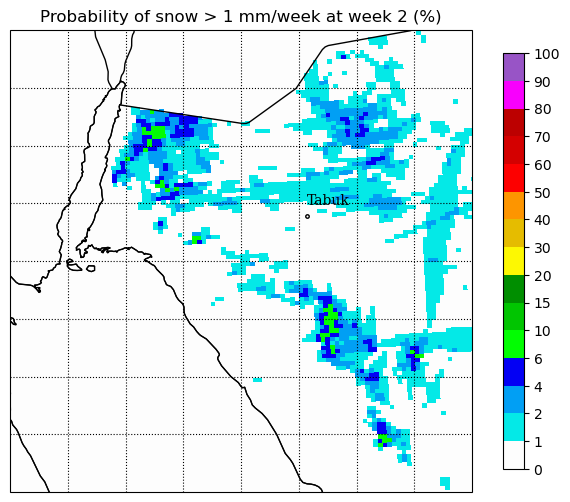

3001


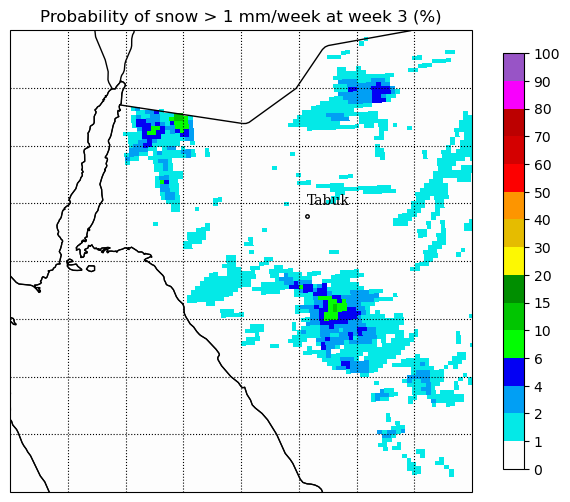

4001


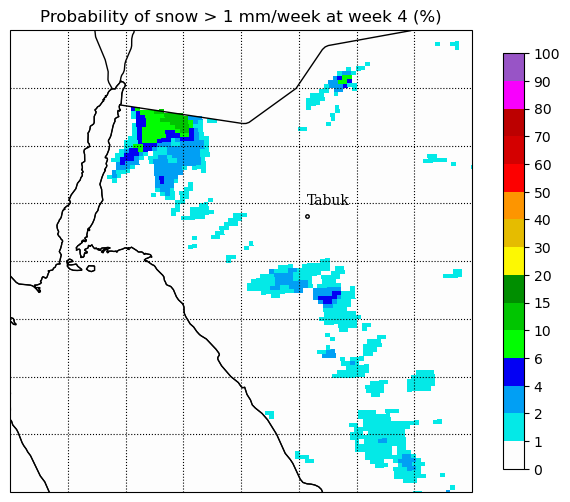

5001


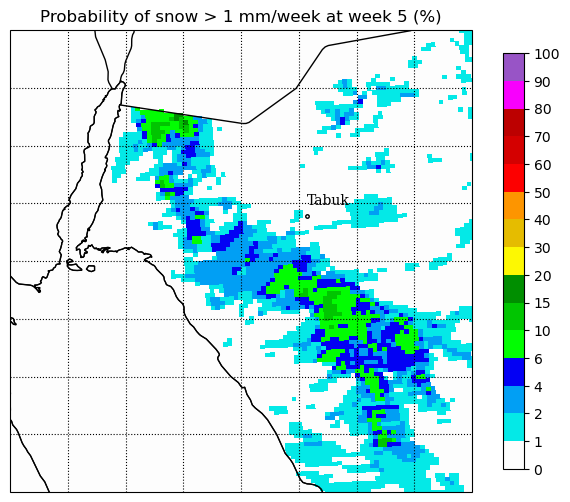

6001


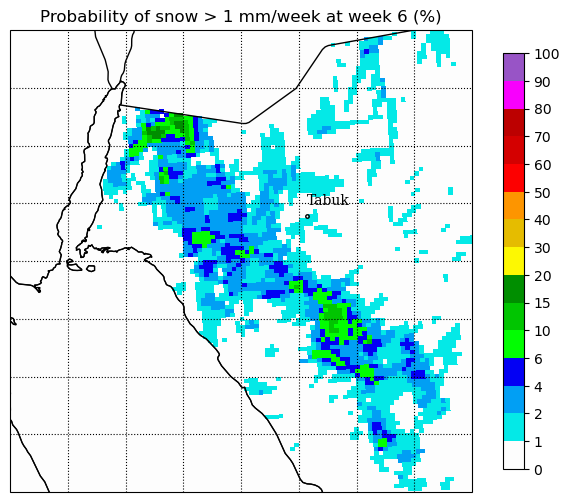

In [48]:
levels = [0, 1, 2, 4, 6, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
norm = mpl.colors.BoundaryNorm(levels, 15)
#projection = ccrs.PlateCarree()
for t in range(0,6):
        print((t+1)*1000+thres)
        prec = sn.isel(Time=t)*m
        start_time = time.time()
        prob = xr.where(prec>thres,100,0)
        levels = [0, 1, 2, 4, 6, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        plot('snow',prob.mean(dim='record',skipna=True),'Probability',thres,t,' (%)',levels)

1001


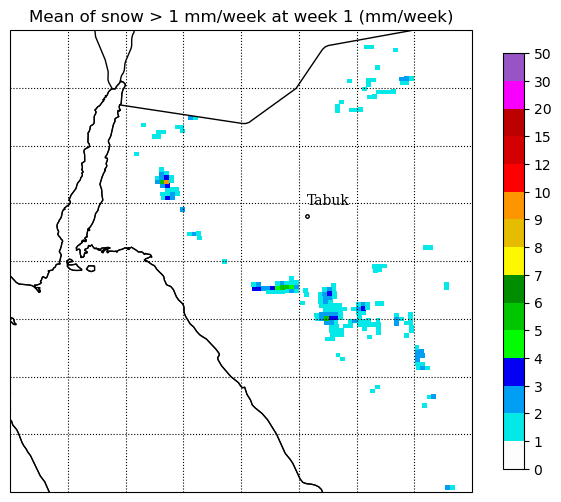

2001


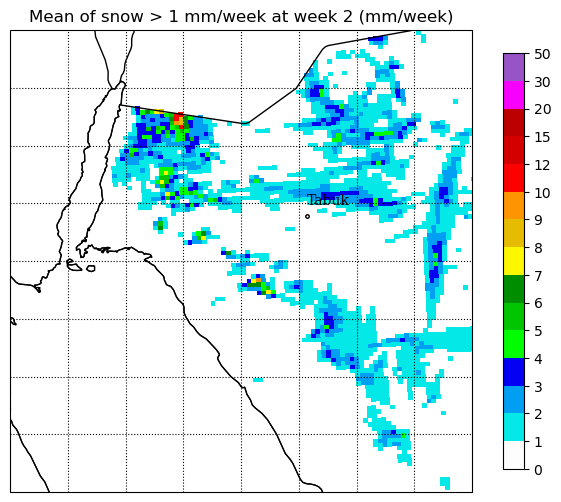

3001


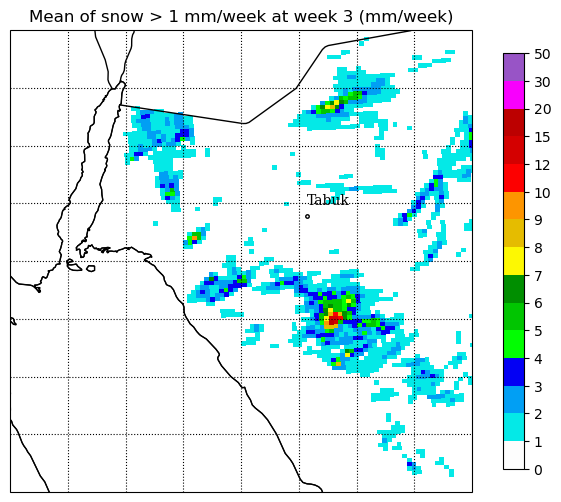

4001


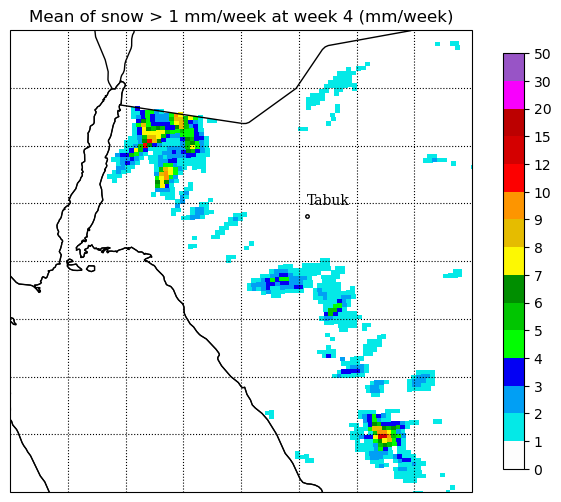

5001


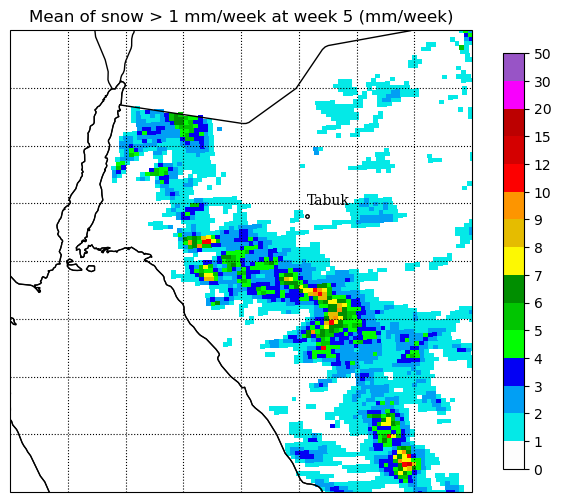

6001


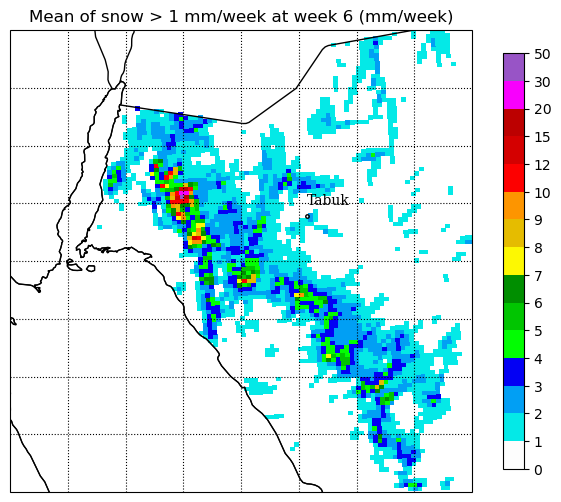

In [49]:
projection = ccrs.PlateCarree()
levels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 50]
for t in range(0,6):
        print((t+1)*1000+thres)
        prec = sn.isel(Time=t)*m
        start_time = time.time()
        emean = xr.where(prec>thres,prec,np.nan)
        plot('snow',emean.mean(dim='record', skipna=True),'Mean',thres,t,' (mm/week)',levels)

In [21]:
ecmwf_colors = ['#ffffff','#24e1ee','#1380ee','#2531f5','#f8c4f0','#c741cd','#f805a0',
               '#f0d330','#d6a639','#EE6A24','#ff0000']
pecmwf_colormap = mpl.colors.ListedColormap(ecmwf_colors)
levels = [0, 1, 2, 4, 10, 15, 20, 25, 40, 60, 100, 200]
norm_new = mpl.colors.BoundaryNorm(levels, 12)

In [22]:
# Create a figure NEW COLORMAP!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!    
def plot_new(prec,r,thres,t,unit,levels):
    fig = plt.figure(figsize=(8,6))
    # Set the GeoAxes to the projection used by WRF
    cart_proj = ccrs.PlateCarree()
    ax = plt.axes(projection=cart_proj)

    norm = mpl.colors.BoundaryNorm(levels, 15)

    # Download and add the states and coastlines
    ax.add_feature(cf.BORDERS,zorder=3)
    ax.add_feature(cf.STATES,zorder=3)
    ax.add_feature(cf.COASTLINE,zorder=3)
    ax.coastlines('10m', linewidth=0.8)

#    plt.contourf(to_np(lons), to_np(lats), to_np(prec), levels,
    plt.pcolormesh(lons, lats, prec,
             transform=ccrs.PlateCarree(),
             cmap=pecmwf_colormap, norm=norm_new)
    # Add a color bar
    plt.colorbar(ax=ax, shrink=.9, ticks = levels)

    # Set the map bounds
    ax.set_xlim(31.28, 61.26)
    ax.set_ylim(9.69, 33.56)

    # Add the gridlines
    ax.gridlines(color='black', linestyle='dotted')

    plt.title(str(r)+' of rainfall > '+str(thres)+' mm/week at week '+str(t+1)+unit)
    dir_out = '/home/bayu/Documents/Arabia_Project/PLOTS_S2S/S2S_oper/WRF/20231102/'
    plt.show()
    fig.savefig(dir_out+'RAINNC_PROB_n_MEAN/'+str(thres)+'_mm/'+
                'P_t'+str(t+1)+'_e'+str(r)+'_'+str(thres)+'mm.png', dpi=200)
    plt.close()


1025


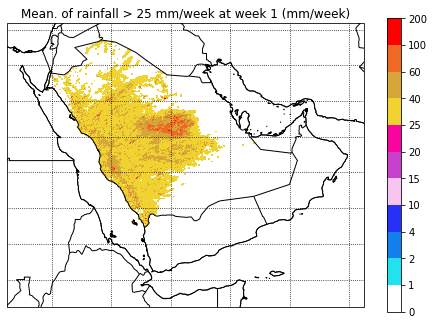

2025


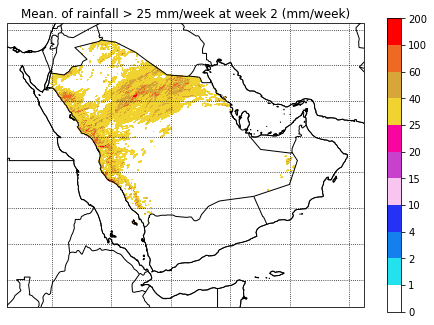

3025


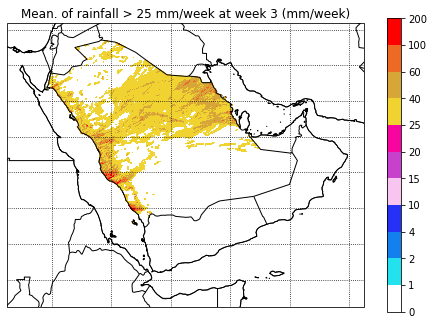

4025


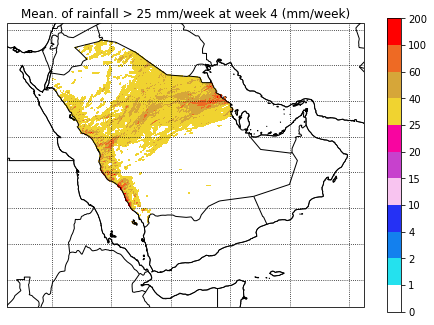

5025


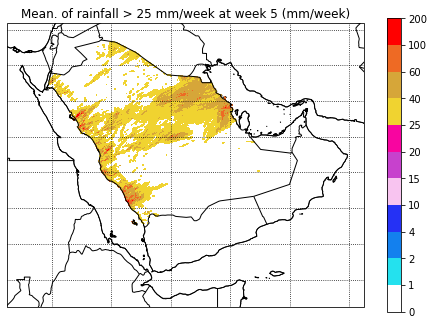

6025


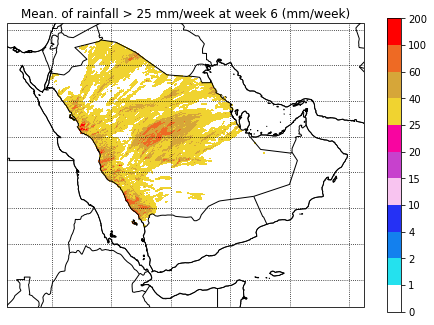

In [23]:
projection = ccrs.PlateCarree()
for t in range(0,6):
        print((t+1)*1000+thres)
        prec = pr.isel(Time=t)*m
        start_time = time.time()
        emean = xr.where(prec>thres,prec,np.nan)
        plot_new(emean.mean(dim='record', skipna=True),'Mean.',thres,t,' (mm/week)',levels)